In [25]:
import os
from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


# Utils

In [73]:
def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp


def plot_point_cloud(pts, title='Point Cloud'):
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  


# Generate

Number of points in simplex grid with N=20: 231


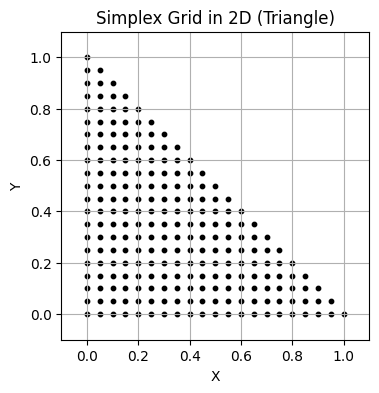

In [27]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 20
pts = []
for l in range(N + 1):
    for j in range(N + 1 - l):
        k = N - l - j
        pts.append((l / N, j / N, k / N))
pts=np.array(pts)

print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')

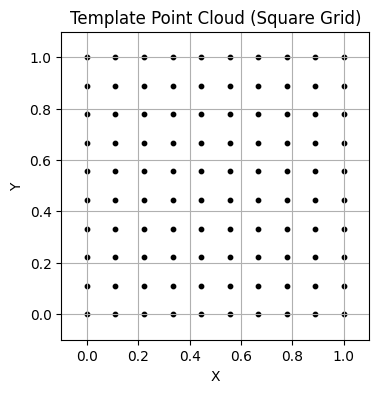

In [28]:
# ----------------------------------------------
# Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 10
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

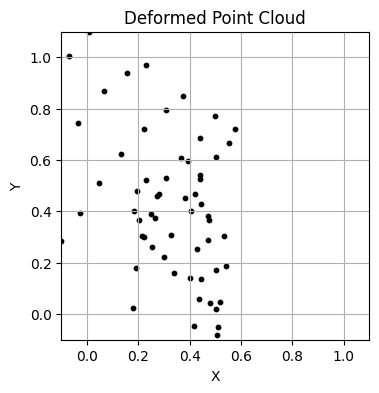

In [ ]:
# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')


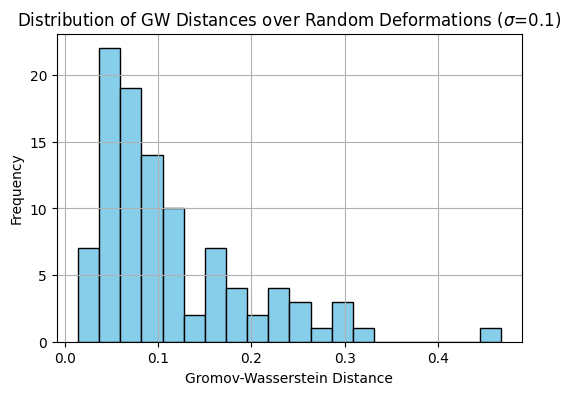

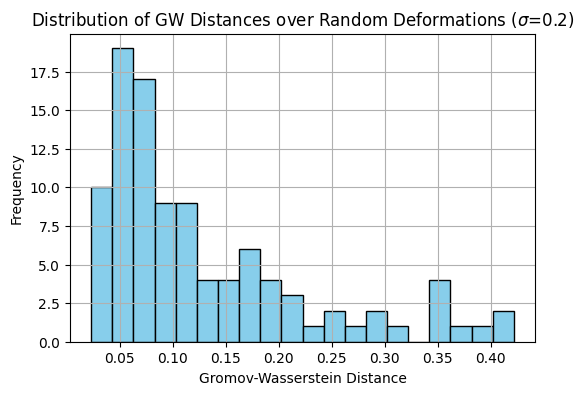

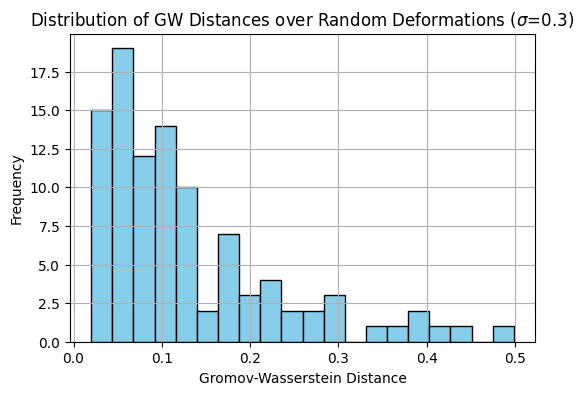

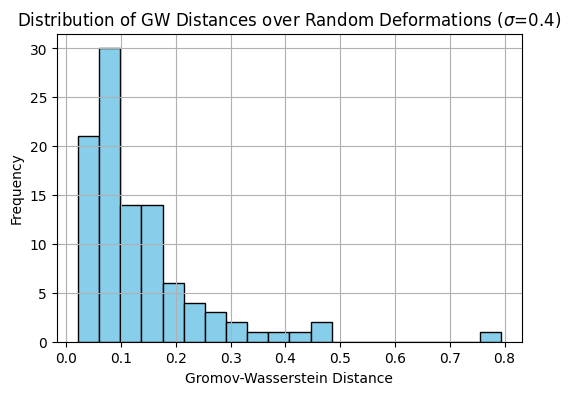

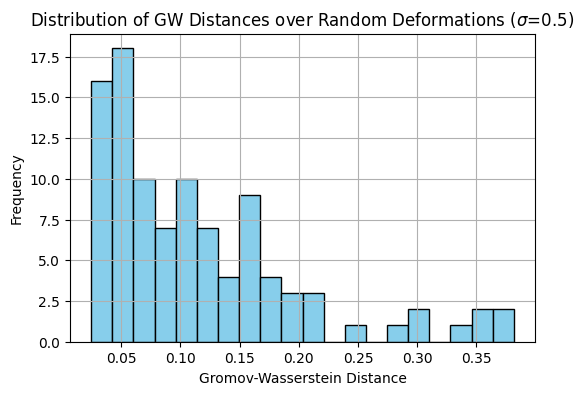

In [ ]:
# ----------------------------------------------
# Explore distribution of GW distances over multiple runs to test how the deformation varies the GW distance
# ----------------------------------------------

sigma = 0.2
num_control = 5
max_disp = 2.0

for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    gw_dist_list = np.zeros(100)
    template_dist_matrix = compute_distance_matrix(template_pts)
    for i in range(len(gw_dist_list)):
        deformed_pts, disp, ctrl_pts, ctrl_disp = random_rbf_deformation(
        template_pts,
        num_ctrl=10,
        sigma=0.2,
        max_disp=1,
        )
        gw_dist_list[i] = ot.gromov.gromov_wasserstein2(
            compute_distance_matrix(deformed_pts),
            template_dist_matrix,
            ot.unif(deformed_pts.shape[0]),
            ot.unif(template_pts.shape[0]),
            'square_loss'
        )

    plt.figure(figsize=(6,4))
    plt.hist(gw_dist_list, bins=20, color='skyblue', edgecolor='k')
    plt.xlabel('Gromov-Wasserstein Distance')
    plt.ylabel('Frequency')
    plt.title(rf'Distribution of GW Distances over Random Deformations ($\sigma$={sigma})')
    plt.grid()
    plt.show()


Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Found deformation with GW distance 0.5675 > 0.5
Parameters: sigma=0.1625, num_control=17, max_disp=1.4765


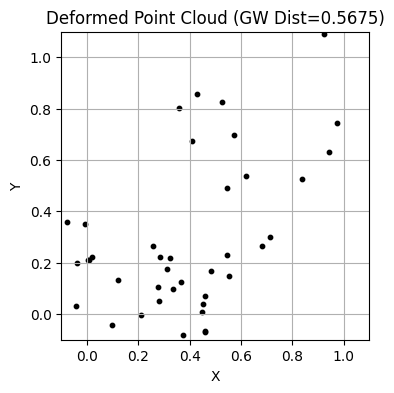

Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Found deformation with GW distance 0.8600 > 0.5
Parameters: sigma=0.1018, num_control=16, max_disp=1.4021


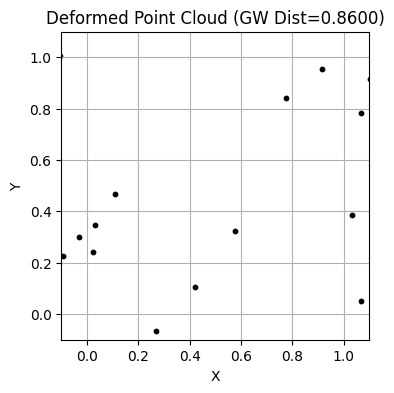

Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iteration 60/100
Iteration 61/100
Iteration 62/100
Iteration 63/100
Iteration 64/100
Iteration 65/100
Iteration 66/100
Iteration 67/100
Iteration 68/100
Iteration 69/100
Iteration 70/100
Iteration 71/100
Iteration 72/100
Iteration 73/100
Iteration 74/100
Iteration 75/100
Found deformation with GW distance 0.6992 > 0.5
Parameters: sigma=0.2119, num_control=16, max_disp=1.2498


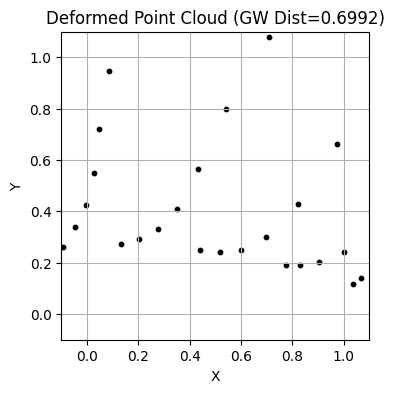

Iteration 76/100
Iteration 77/100
Iteration 78/100
Iteration 79/100
Iteration 80/100
Iteration 81/100
Iteration 82/100
Iteration 83/100
Iteration 84/100
Iteration 85/100
Iteration 86/100
Iteration 87/100
Iteration 88/100
Iteration 89/100
Iteration 90/100
Iteration 91/100
Iteration 92/100
Iteration 93/100
Iteration 94/100
Iteration 95/100
Iteration 96/100
Iteration 97/100
Iteration 98/100
Iteration 99/100
Iteration 100/100


In [105]:
# ----------------------------------------------
# Search for three deformation parameters that yield GW distances to the uniform template larger than a threshold
# ----------------------------------------------        

template_dist_matrix = compute_distance_matrix(template_pts)
threshold = 0.5
parameter_records = []
for i in range(100):
    print(f'Iteration {i+1}/100')
    sigma = np.random.uniform(0.1, 0.5)
    num_control = np.random.randint(5, 20)
    max_disp = np.random.uniform(0.5, 1.5)

    deformed_pts, disp, ctrl_pts, ctrl_disp = random_rbf_deformation(
        template_pts,
        num_ctrl=num_control,
        sigma=sigma,
        max_disp=max_disp,
    )
    gw_dist = ot.gromov.gromov_wasserstein2(
        compute_distance_matrix(deformed_pts),
        template_dist_matrix,
        ot.unif(deformed_pts.shape[0]),
        ot.unif(template_pts.shape[0]),
        'square_loss'
    )

    if gw_dist > threshold:
        parameter_records.append((sigma, num_control, max_disp, gw_dist))
        print(f'Found deformation with GW distance {gw_dist:.4f} > {threshold}')
        print(f'Parameters: sigma={sigma:.4f}, num_control={num_control}, max_disp={max_disp:.4f}')
        plot_point_cloud(deformed_pts, title=f'Deformed Point Cloud (GW Dist={gw_dist:.4f})')    

In [106]:
# -----------------------------------------------
# Save generated point clouds and distance matrices to disk
# -----------------------------------------------
output_dir = Path('./20-Exp-generated_data')       
os.makedirs(output_dir, exist_ok=True)
# Save template point cloud and distance matrix
template_dist_matrix = compute_distance_matrix(template_pts)
np.savez_compressed(output_dir / 'template_point_cloud.npz',
                        points=template_pts,
                        distance_matrix=template_dist_matrix)
# Save deformed point clouds and distance matrices for each parameter set found
for idx, (sigma, num_control, max_disp, gw_dist) in enumerate(parameter_records):
    deformed_pts, disp, ctrl_pts, ctrl_disp = random_rbf_deformation(
        template_pts,
        num_ctrl=num_control,
        sigma=sigma,
        max_disp=max_disp,
    )
    dist_matrix = compute_distance_matrix(deformed_pts)
    np.savez_compressed(
        output_dir / f'deformed_point_cloud_{idx+1}.npz',
        points=deformed_pts,
        distance_matrix=dist_matrix,
        sigma=sigma,
        num_control=num_control,
        max_disp=max_disp,
        gw_distance=gw_dist
    )
print(f'Saved {len(parameter_records)} deformed point clouds to {output_dir}')

Saved 3 deformed point clouds to 20-Exp-generated_data


In [107]:
# ----------------------------------------------
# Compute pairwise GW distance matrix between all generated point clouds
# ----------------------------------------------
num_clouds = len(parameter_records) + 1  # +1 for the template
gw_distance_matrix = np.zeros((num_clouds, num_clouds))     

# Load template distance matrix
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
gw_distance_matrix[0, 0] = 0.0  # GW distance of template to itself is zero
# Compute GW distances between template and deformed clouds
for idx in range(1, num_clouds):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_dist_matrix = deformed_data['distance_matrix']
    gw_dist = ot.gromov.gromov_wasserstein2(
        deformed_dist_matrix,
        template_dist_matrix,
        ot.unif(deformed_dist_matrix.shape[0]),
        ot.unif(template_dist_matrix.shape[0]),
        'square_loss'
    )
    gw_distance_matrix[0, idx] = gw_dist
    gw_distance_matrix[idx, 0] = gw_dist    
# Compute GW distances between deformed clouds
for i in range(1, num_clouds):
    for j in range(i + 1, num_clouds):
        data_i = np.load(output_dir / f'deformed_point_cloud_{i}.npz')
        data_j = np.load(output_dir / f'deformed_point_cloud_{j}.npz')
        dist_matrix_i = data_i['distance_matrix']
        dist_matrix_j = data_j['distance_matrix']
        gw_dist = ot.gromov.gromov_wasserstein2(
            dist_matrix_i,
            dist_matrix_j,
            ot.unif(dist_matrix_i.shape[0]),
            ot.unif(dist_matrix_j.shape[0]),
            'square_loss'
        )
        gw_distance_matrix[i, j] = gw_dist
        gw_distance_matrix[j, i] = gw_dist   

# Print GW distance matrix
print('Pairwise GW Distance Matrix:')
print(gw_distance_matrix)      
           


Pairwise GW Distance Matrix:
[[0.         0.44447685 0.19419992 0.14732263]
 [0.44447685 0.         0.13727318 0.14777474]
 [0.19419992 0.13727318 0.         0.0832398 ]
 [0.14732263 0.14777474 0.0832398  0.        ]]
